In [1]:
! git clone https://github.com/Duckkyy/3rd_year_experiment.git

Cloning into '3rd_year_experiment'...
remote: Enumerating objects: 37126, done.
remote: Counting objects: 100% (2230/2230), done.
remote: Compressing objects: 100% (2100/2100), done.
remote: Total 37126 (delta 120), reused 2229 (delta 119), pack-reused 34896
Receiving objects: 100% (37126/37126), 913.52 MiB | 38.30 MiB/s, done.
Resolving deltas: 100% (14164/14164), done.
Updating files: 100% (38760/38760), done.


In [2]:
!ls 3rd_year_experiment/emotions/data/train
import shutil
import os
train_dir = '3rd_year_experiment/emotions/data/train'
val_dir = '3rd_year_experiment/emotions/data/val'
for i in range(1, 8):
    val_dir_idx = os.path.join(val_dir, str(i))
    train_dir_idx = os.path.join(train_dir, str(i))
    for fol in os.listdir(val_dir_idx):
        val_dir_path = os.path.join(val_dir_idx, fol)
        train_dir_path = os.path.join(train_dir_idx, fol)
        for image in os.listdir(val_dir_path):
            val_image_path = os.path.join(val_dir_path, image)
            # print(val_image_path)
            shutil.copy(val_image_path, train_dir_path)

1  2  3  4  5  6  7


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import cv2
from torch.utils.data import Dataset, DataLoader
import io 
import os 
from PIL import Image

In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time 
import copy

In [5]:
#Dataloader
data_path = '3rd_year_experiment/emotions/data/'
#Path for training and testing directory
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

In [6]:
train_data_path = '3rd_year_experiment/emotions/Labels/ground_truth_train.csv'
train_data = pd.read_csv(train_data_path)
train_data.head(5)

,image,label
0,disgust/1.jpg,2
1,surprise/1.jpg,4
2,fear/1.jpg,3
3,joy/1.jpg,4
4,sadness/1.jpg,5


In [7]:
labelArr = train_data['label'].unique()
label2id = {}
id2label = {}
index = 0
for class_name in labelArr:
    label2id[class_name] = str(index)
    id2label[str(index)] = class_name
    index += 1
print(label2id)
print(id2label)

{2: '0', 4: '1', 3: '2', 5: '3', 7: '4', 6: '5', 1: '6'}
{'0': 2, '1': 4, '2': 3, '3': 5, '4': 7, '5': 6, '6': 1}


In [8]:
model_name = 'resnet'
num_classes = 7
batch_size = 64
num_epochs = 50
feature_extract = False

In [9]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_data, test_size=0.05)
print(len(train))
print(len(valid))

1507
80


In [10]:
train['label'].value_counts()

4    486
7    252
3    251
5    228
2    188
6     79
1     23
Name: label, dtype: int64

In [11]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 1]), self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(label2id[labelKey]))
            
        else:
            label = torch.tensor(1)
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [12]:
input_size = 224
transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
train_dataset = EmotionDataset(train, root_dir=train_dir, is_train=True, transform=transform_train)
valid_dataset = EmotionDataset(valid, root_dir=train_dir, is_train=True, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
dataloaders_dict ={}
dataloaders_dict['train']= train_loader
dataloaders_dict['val'] = val_loader

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2314.)
  import sys


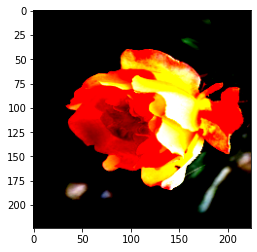

Label: 2


In [15]:
# for i, (images,labels) in enumerate(train_loader):
#     print(images)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
img = (img.T).detach().numpy()
label = train_labels[0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Label: {label}")

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        #models.resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_classes)
                                    )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_classes)
                                    )
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

model_name = 'densenet'
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
# Send the model to GPU
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print(f'using {device} device')
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=2e-3, momentum=0.9,weight_decay=1e-6, nesterov=True)
#optimizer_ft = optim.Adam(params_to_update, lr=1e-3)

using cuda device
Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.we

In [20]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 1.6836 Acc: 0.3437
val Loss: 1.4065 Acc: 0.5250

Epoch 1/49
----------
train Loss: 1.3658 Acc: 0.5070
val Loss: 1.2904 Acc: 0.5500

Epoch 2/49
----------
train Loss: 1.2137 Acc: 0.5660
val Loss: 1.1946 Acc: 0.6000

Epoch 3/49
----------
train Loss: 1.1067 Acc: 0.5959
val Loss: 1.2007 Acc: 0.5750

Epoch 4/49
----------
train Loss: 0.9840 Acc: 0.6549
val Loss: 1.2067 Acc: 0.5625

Epoch 5/49
----------
train Loss: 0.8864 Acc: 0.6954
val Loss: 1.1991 Acc: 0.6125

Epoch 6/49
----------
train Loss: 0.7921 Acc: 0.7233
val Loss: 1.2134 Acc: 0.5875

Epoch 7/49
----------
train Loss: 0.6893 Acc: 0.7764
val Loss: 1.1886 Acc: 0.5875

Epoch 8/49
----------
train Loss: 0.6128 Acc: 0.8016
val Loss: 1.1481 Acc: 0.6125

Epoch 9/49
----------
train Loss: 0.5249 Acc: 0.8427
val Loss: 1.2094 Acc: 0.5625

Epoch 10/49
----------
train Loss: 0.4389 Acc: 0.8673
val Loss: 1.1980 Acc: 0.6250

Epoch 11/49
----------
train Loss: 0.3782 Acc: 0.9011
val Loss: 1.2403 Acc: 0.6125

Ep

In [21]:
class TestDataset(Dataset):
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,self.dataframe.iloc[idx, 0]

In [22]:
label_path = "3rd_year_experiment/emotions/Labels"
test_label_path = os.path.join(label_path, "ground_truth_test.csv")
test_dataframe = pd.read_csv(test_label_path)
test_dataframe.head()

,image
0,anger/230.jpg
1,disgust/245.jpg
2,disgust/249.jpg
3,joy/253.jpg
4,disgust/255.jpg


In [23]:
data_path = '3rd_year_experiment/emotions/data/'
test_dir = os.path.join(data_path, "test")
print(os.listdir(test_dir))

['surprise', 'sadness', 'joy', 'anger', '.DS_Store', 'fear', 'disgust']


In [24]:
test_dataset = TestDataset(test_dataframe, root_dir=test_dir, transform=transform_valid)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2)

In [25]:
#model_ft.cuda()
model_ft.eval()
filenames=[]
finalpredictions=[]
for inputs, files in test_loader:
                # print(inputs)
                # print(files)
                inputs = inputs.to(device)
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                finalpred=[]
                for file in files:
                    filenames.append(file)
                for pred in preds:
                    finalpredictions.append(id2label[str(pred.item())])
                #print(finalpred)

RuntimeError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 14.76 GiB total capacity; 13.21 GiB already allocated; 79.75 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [40]:
df_preds = pd.DataFrame({'image': filenames, "label": finalpredictions})
df_preds.head()

,image,label
0,anger/230.jpg,6
1,disgust/245.jpg,2
2,disgust/249.jpg,7
3,joy/253.jpg,4
4,disgust/255.jpg,2


In [42]:
df_preds.to_csv("sample_submission1.csv", index=False)

In [ ]:
print(len(submission_df))

In [26]:
torch.save(model_ft,"EmotionDensenet.pt")